In [1]:
# suppress warnings
import warnings
warnings.simplefilter('ignore')
# import installed packages
import pandas as pd
import numpy as np
import xarray as xr
from statsmodels.tsa.seasonal import STL
# import functions from custom modules
import sys
sys.path.insert(0,'/Users/Kathy/Desktop/UW/seaflow/decomposition_project/scripts/')
from diel_tools import *
from fig_tools import *
from tsd_functions import *
from rate_functions import *
from simulation_tools import *

# Generate simulated 10 day dataset from Zinser et al experimental data
1. Combine Hourly Qc data, PAR, gross 14C fixation, carbon loss into one dataset. 
>a) Calculate net carbon fixation from gross fixation and carbon loss
2. Repeat days from original dataset 5x to get 10 day simulated dataset.
3. Randomly remove data of certain percentages.
4. Run iterative interpolation to impute new values. 
5. Compare imputed values against original values to calculate error (RMSE).
6. Block bootstrap to get uncertainites for productivity measurements.

### Calculating hourly Qc from FCM and combining with measurements data
Returns single dataframe with all necessary data for analysis: `pro_data`

In [2]:
# read in flow cytometry data
culture_data=pd.read_csv('simulation_data/zinser_figure2a.csv')
psd_data=pd.read_csv('simulation_data/zinser_psd.csv')

#### reformat to calculate hourly average Qc ####
# get experimental time from culture dataset
X = list(culture_data['exper time'])
# get size classes from psd data columns
Y = list(psd_data.columns[1:].astype(float))
# get particle size distrubition data from dataframe
Z = psd_data.iloc[:,1:].T.to_numpy()

# make new dataframe with particle size distribution data and reset the index
df = pd.DataFrame(data=Z, columns=X, index=Y).reset_index()
# rename column to size_bin
df.rename(columns={'index':'size_bin'},inplace=True)
# reformat data from wide to long
df_long=pd.melt(df, id_vars=['size_bin'], var_name='hour', value_name='abundance')
# calculate sum of each size bin using size and abundance
df_long['Qc_sum'] = df_long['size_bin'] * df_long['abundance']
# filter out size classes with no abundance
df_long = df_long[df_long.abundance > 0]

# group by cruise and date to get n and summed qc by the hour
df_group = df_long.groupby(['hour']).sum().reset_index()
# get mean Qc per hour and convert Qc from fg -> pg
df_group['Qc_hour'] = (df_group['Qc_sum']/df_group['abundance'])/1000
# subset just the columns we care about
pro_data = df_group[['hour','Qc_hour']]

#### Add in PAR and measurements data ####
# get PAR data
ds = xr.open_dataset('simulation_data/zinser_processed.nc',
                    decode_times=False)
pro_data['par']=ds.PAR.values
# get c-fixation and loss data
gt = xr.open_dataset('simulation_data/zinser_ground_truth.nc',
                    decode_times=False)
# get carbon fixation for all rows in pg
pro_data['GPP']=gt.carbonfix.values/1000
# get carbon loss for all rows except last in pg
pro_data.loc[0:23,'carbonloss']=gt.carbonloss.values/1000
# add net c-fiszation for all rows
pro_data['NPP'] = pro_data['GPP']-pro_data['carbonloss']

### Generate 10 day simulated dataset
Cuts off the last day to repeat to produce continuous transition into next simulated days

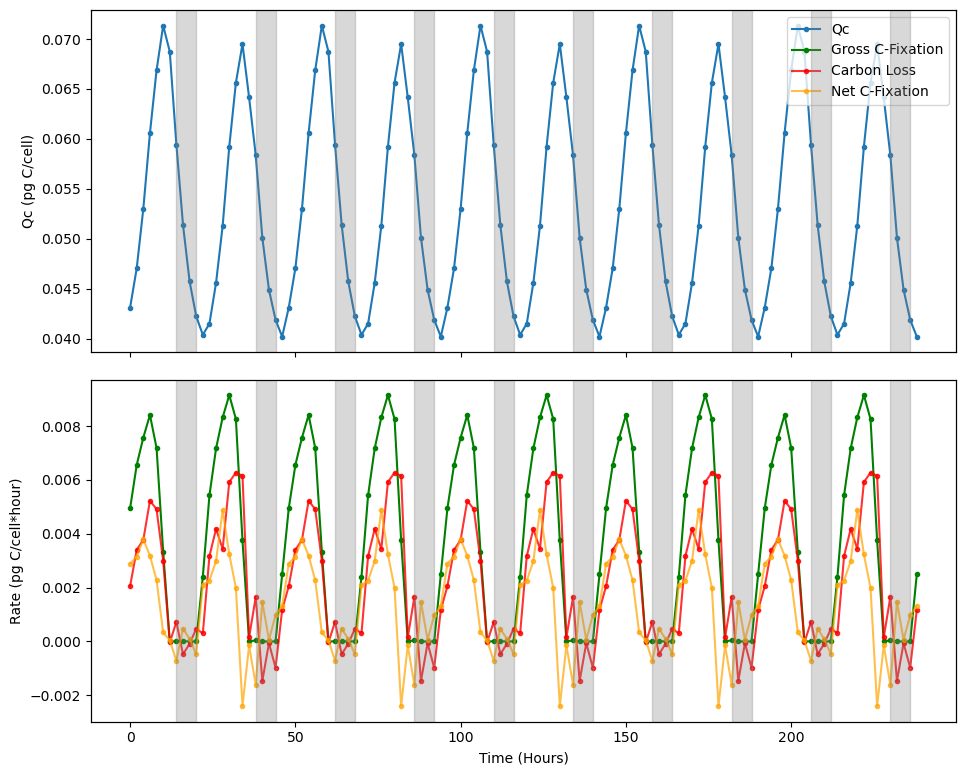

In [3]:
# create 10 day simulated data for Qc data
ten_days=generate_simulated(pro_data, 10)

#### Plot to check if simulation successful ####
plot_simulated_rates(ten_days)

### Randomly remove data 
Try with varying percentages of missing data

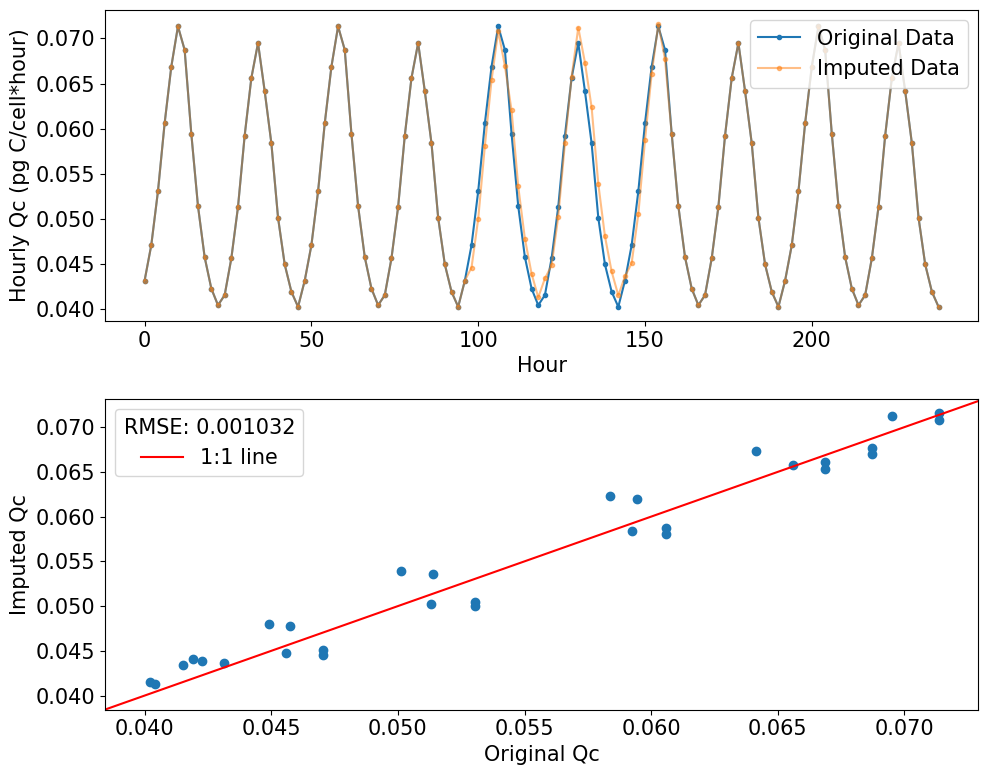

In [4]:
from sklearn.metrics import mean_squared_error
# generate missing data
# missing_25=generate_missing_data(ten_days, 0.25)
missing_25=generate_missing_chunks(ten_days, 30, 0.25)
# calculate imputed values
impute_df=run_imputation(missing_25)

#### plot results ####
plot_imputed(impute_df)

### Calculate Imputation Error Metrics
Percent Bias (PB), Coverage Rate (CR), and Average Width (AW) ([Reference](https://stefvanbuuren.name/fimd/sec-evaluation.html))
- Percent Bias is calculated by taking the average of (actual - predicted) / abs(actual) across all observations. ([reference](https://rdrr.io/cran/Metrics/man/percent_bias.html#:~:text=Percent%20Bias%20is%20calculated%20by,(actual)%20across%20all%20observations.)
- Coverage rate/probability is calculated by the number of true values that fall within the CI (here I use 95% but not sure if too wide/narrow). We can simulate many runs to get an average lower/upper q, then check each true value against the CI range. 

In [5]:
# # store data here
# dfs=[]
# # calculate qs
# low_q=[]
# up_q=[]
# # simulate runs
# for n in range(0,100):
#     missing_25=generate_missing_chunks(ten_days, 30, 0.25)
#     # calculate imputed values
#     impute_df=run_imputation(missing_25)
#     # store vals
#     dfs.append(impute_df)
#     low_q.append(lower_q(impute_df['with_missing']))
#     up_q.append(upper_q(impute_df['with_missing']))
    
# ## helper function to calculate percent bias
# def calc_pb(df):
#     obs=df['Qc_hour']
#     pred=df['with_missing']
#     return np.mean((obs-pred)/np.abs(obs)) * 100


# sim_dfs=pd.concat(dfs)
# calc_pb(sim_dfs)
# # calculate mean CI
# mean_low, mean_up = np.mean(low_q), np.mean(up_q)
# # how many observed values fall within CI

### Calculate growth rates and productivity on imputed datasets
Compare against measurements to get error

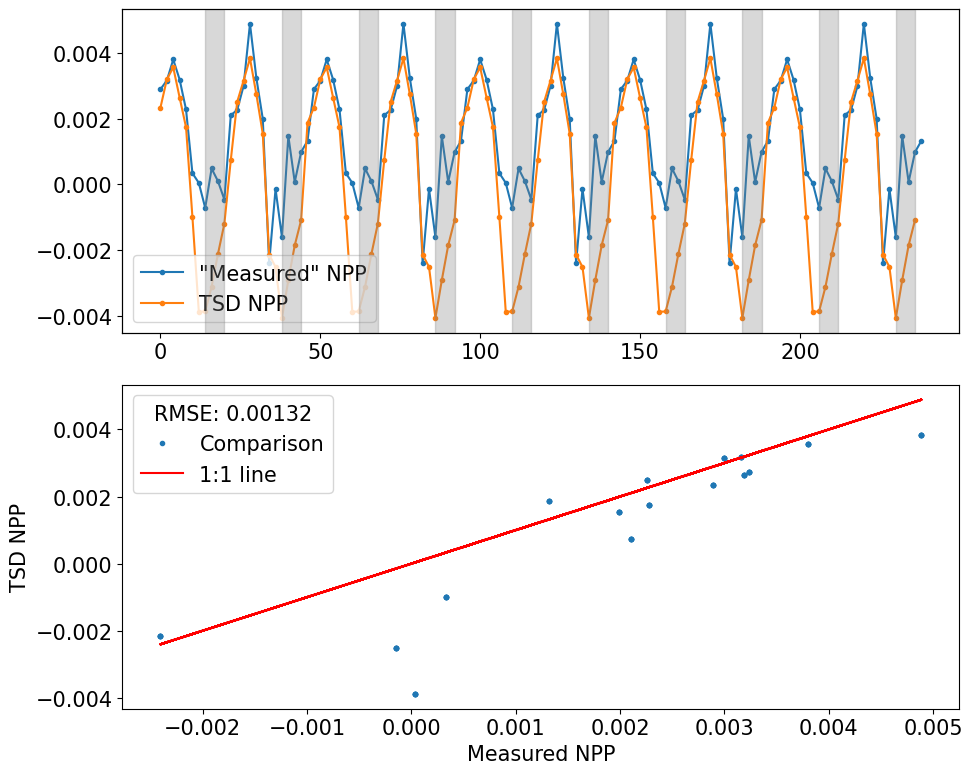

In [5]:
# suppress warnings
import warnings
warnings.simplefilter('ignore')

# get tsd components
tsd_df=run_STL(impute_df, 'with_missing')
# calculate hourly growth by exponential growth and maintain correct order
tsd_df['hourly_growth']=exp_growth(tsd_df, 'diel',2).shift(-1)
# calculate hourly productivity
rates_df=calc_productivity(tsd_df,'hourly_growth','Qc_hour')

#### Plot results ####
fig,rmse=plot_productivity(tsd_df)

### Create baseline
Calculate growth rate and productivity without decomposition

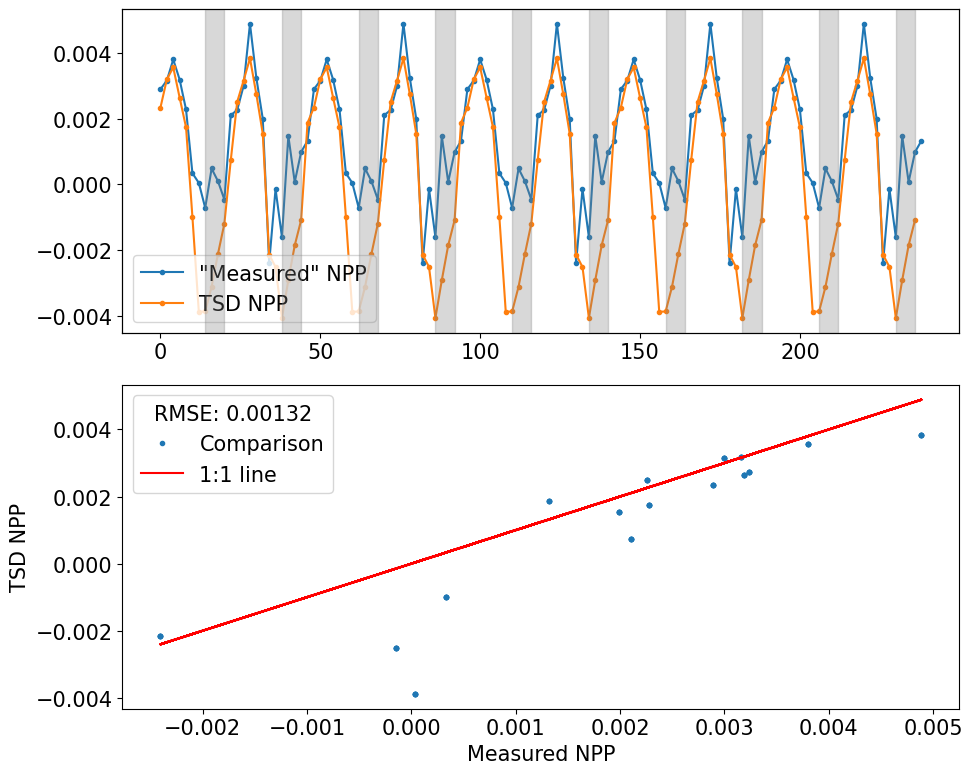

In [6]:
## generate simulated data
base_growth=exp_growth(ten_days,'Qc_hour',2).shift(-1)
# add to data
baseline=ten_days.copy()
baseline['hourly_growth']=base_growth
baseline=calc_productivity(baseline, 'hourly_growth','Qc_hour')
# plot
fig,rmse=plot_productivity(baseline)

### Run moving block bootstrapping (MBB) on models to get uncertainty values

1. Get residual values
2. Separate residuals into _l_ length blocks
3. Randomly draw with resampling to create new time series of residuals
4. Combine with seasonal and trend components to generate new synthetic time series
5. Calculate new productivity values from synthetic time series
6. Repeat **_n_** times to get distribution of error

#### References
- Medium [guide](https://medium.com/@daydreamersjp/bootstrapping-on-time-series-data-moving-block-bootstrap-79aaf6648aec)
- Bergmeier et al. [slides](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://cbergmeir.com/talks/bergmeir2014ISF_slides.pdf)
- Medium [tutorial (with paywall)](https://archive.ph/LSshc)


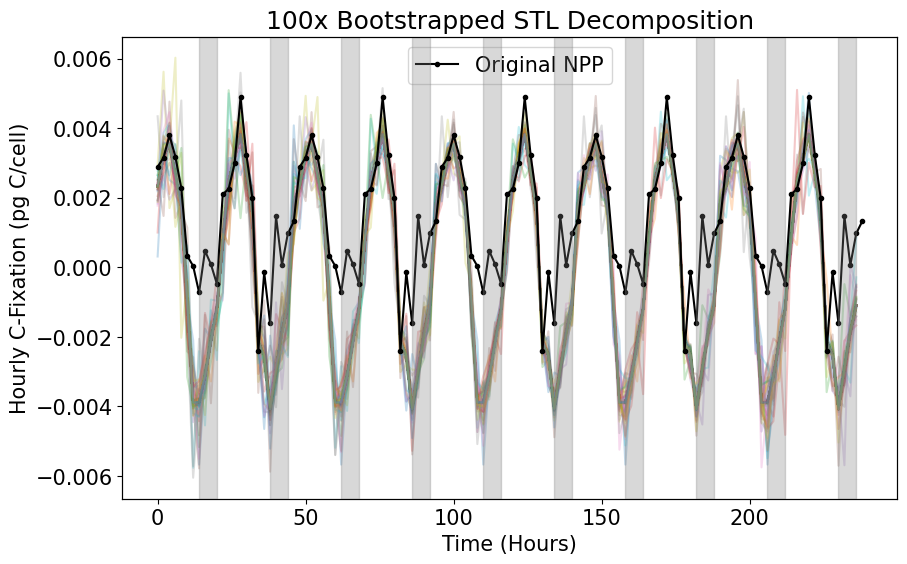

In [7]:
# run bootstrapping to get list of new dataframes
runs=100
mbb_df, mbb_data=run_bootstrapping(tsd_df, runs=runs)
plot_bootstrapping(mbb_df, mbb_data, runs)

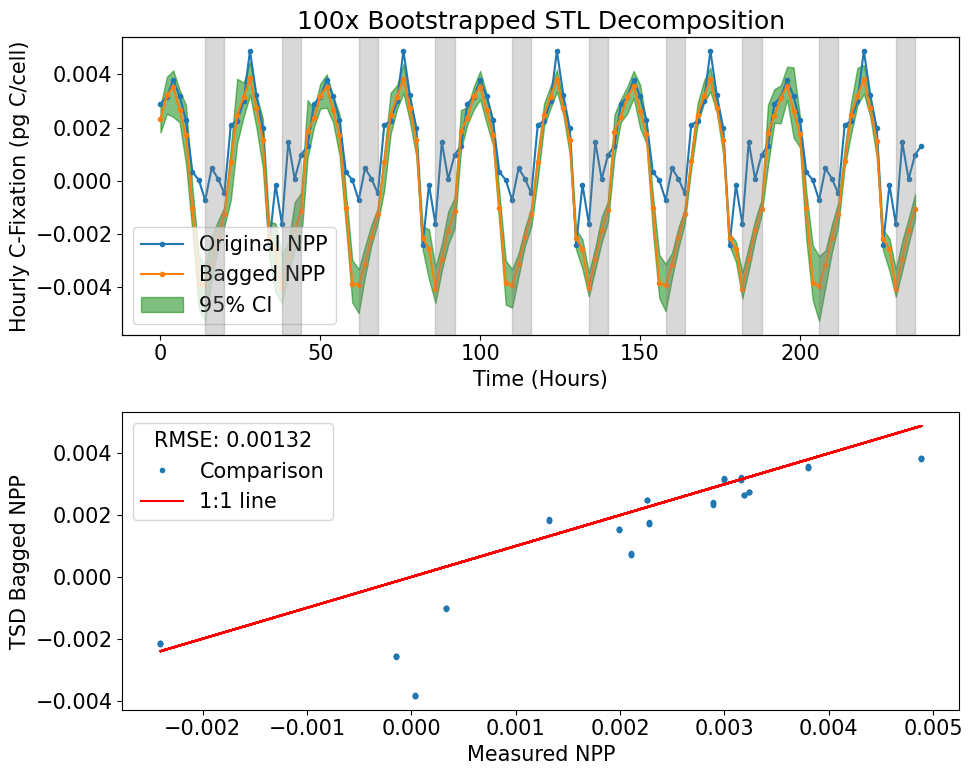

In [8]:
# perform bagging on bootstrapped data
bagged=bagging_results(mbb_data)

## plot results
fig,rmse=plot_bagging(bagged)

### Put it all together and test for amount of data removed
Uncomment cell below to rerun, but this takes about ~15 minutes to complete. Alternatively, run the preloaded pickle file to check previous results 

- This cell runs bagged model 100x to collect aggregated error (RMSE, sMAPE, and mase)  in this case. 

In [12]:
# list of data percentages to remove
to_remove=[0, 0.1, 0.25, 0.4, 0.5, 0.6]
# save error metrics distribution
rmse_dist=[]
smape_dist=[]
mase_dist=[]
# run model 100 times to collect error distributions
for i in range(0,100):
    # save rmses in each proportion
    print(i)
    rmses=[]
    smapes=[]
    mases=[]
    # run model for several iterations
    for prop in to_remove:
        # run model
        rmse, smape, mase=run_full_model(pro_data, 10, prop, model='STL', runs=100, show_plots=True)
        print(f'data removed: {prop} and RMSE: {rmse}')
        # save errors
        rmses.append(rmse)
        smapes.append(smape)
        mases.append(mase)
    # save list of rmses
    rmse_dist.append(rmses)
    smape_dist.append(smapes)
    mase_dist.append(mases)

## Save file
# rmse_df=pd.DataFrame(rmse_dist)
# rmse_df.columns = to_remove
# rmse_df.to_pickle('simulation_data/rmse_df')

0
data removed: 0 and RMSE: 0.001322171705440931
data removed: 0.1 and RMSE: 0.001340113277866201
data removed: 0.25 and RMSE: 0.0013812792523540058
data removed: 0.4 and RMSE: 0.0014345121336700752
data removed: 0.5 and RMSE: 0.0014537258200443893
data removed: 0.6 and RMSE: 0.0018766301698190369
1
data removed: 0 and RMSE: 0.001322171705440931
data removed: 0.1 and RMSE: 0.0013203829346250594
data removed: 0.25 and RMSE: 0.001359246596131386
data removed: 0.4 and RMSE: 0.001743307983768923
data removed: 0.5 and RMSE: 0.0013534083442657858
data removed: 0.6 and RMSE: 0.0013701540871840856
2
data removed: 0 and RMSE: 0.001322171705440931
data removed: 0.1 and RMSE: 0.0013204800812511735
data removed: 0.25 and RMSE: 0.0015129522456102124
data removed: 0.4 and RMSE: 0.0015061160493168987
data removed: 0.5 and RMSE: 0.0014833256049928958
data removed: 0.6 and RMSE: 0.001640817611720707
3
data removed: 0 and RMSE: 0.001322171705440931
data removed: 0.1 and RMSE: 0.001317296957039171
data r

data removed: 0.4 and RMSE: 0.0016453831884987412
data removed: 0.5 and RMSE: 0.001760071808651812
data removed: 0.6 and RMSE: 0.001507181817338034
28
data removed: 0 and RMSE: 0.001322171705440931
data removed: 0.1 and RMSE: 0.0012400284775733236
data removed: 0.25 and RMSE: 0.0012716592687220302
data removed: 0.4 and RMSE: 0.0017383520287405252
data removed: 0.5 and RMSE: 0.0017012350264615306
data removed: 0.6 and RMSE: 0.0013797192009735464
29
data removed: 0 and RMSE: 0.001322171705440931
data removed: 0.1 and RMSE: 0.0013220605334771623
data removed: 0.25 and RMSE: 0.0014012517600356957
data removed: 0.4 and RMSE: 0.001557513416248601
data removed: 0.5 and RMSE: 0.00152149036174023
data removed: 0.6 and RMSE: 0.0015643491960371382
30
data removed: 0 and RMSE: 0.001322171705440931
data removed: 0.1 and RMSE: 0.0014060291026067903
data removed: 0.25 and RMSE: 0.0013242437014697476
data removed: 0.4 and RMSE: 0.0015116230496693573
data removed: 0.5 and RMSE: 0.0015110278563126105
da

data removed: 0 and RMSE: 0.001322171705440931
data removed: 0.1 and RMSE: 0.0013229517021092576
data removed: 0.25 and RMSE: 0.0016877791621380802
data removed: 0.4 and RMSE: 0.0017616170305972496
data removed: 0.5 and RMSE: 0.0013747285253291914
data removed: 0.6 and RMSE: 0.0013323489844177705
56
data removed: 0 and RMSE: 0.001322171705440931
data removed: 0.1 and RMSE: 0.001395268285963949
data removed: 0.25 and RMSE: 0.0013285196665354204
data removed: 0.4 and RMSE: 0.0015378581919206526
data removed: 0.5 and RMSE: 0.0014097272990466613
data removed: 0.6 and RMSE: 0.0017618688565339306
57
data removed: 0 and RMSE: 0.001322171705440931
data removed: 0.1 and RMSE: 0.0013235166166633242
data removed: 0.25 and RMSE: 0.0013174477521356513
data removed: 0.4 and RMSE: 0.0018677464232121897
data removed: 0.5 and RMSE: 0.0012533977719847004
data removed: 0.6 and RMSE: 0.0015658018311370489
58
data removed: 0 and RMSE: 0.001322171705440931
data removed: 0.1 and RMSE: 0.0013163028531952045
d

data removed: 0.25 and RMSE: 0.0013155083081546866
data removed: 0.4 and RMSE: 0.001635138895514414
data removed: 0.5 and RMSE: 0.0015068613329174577
data removed: 0.6 and RMSE: 0.0016257469765781055
83
data removed: 0 and RMSE: 0.001322171705440931
data removed: 0.1 and RMSE: 0.0014147975885226525
data removed: 0.25 and RMSE: 0.0013909435901452742
data removed: 0.4 and RMSE: 0.0013300257676783346
data removed: 0.5 and RMSE: 0.0013244772700216523
data removed: 0.6 and RMSE: 0.0013959957225934013
84
data removed: 0 and RMSE: 0.001322171705440931
data removed: 0.1 and RMSE: 0.0013280497557753344
data removed: 0.25 and RMSE: 0.001339961059804179
data removed: 0.4 and RMSE: 0.0016807202583068181
data removed: 0.5 and RMSE: 0.0013461029332698666
data removed: 0.6 and RMSE: 0.0014923813491950306
85
data removed: 0 and RMSE: 0.001322171705440931
data removed: 0.1 and RMSE: 0.0013237143163322468
data removed: 0.25 and RMSE: 0.0013385209126604832
data removed: 0.4 and RMSE: 0.001450788164178028

In [30]:
print('saving dfs...')
to_df(rmse_dist, to_remove, 'RMSE').to_pickle('simulation_data/stl_rmse_df')
to_df(smape_dist, to_remove, 'sMAPE').to_pickle('simulation_data/stl_smape_df')
to_df(mase_dist, to_remove, 'MASE').to_pickle('simulation_data/stl_mase_df')

saving dfs...


In [33]:
#### For baseline model

# list of data percentages to remove
to_remove=[0, 0.1, 0.25, 0.4, 0.5, 0.6]
# save error metrics distribution
rmse_dist=[]
smape_dist=[]
mase_dist=[]
# run model 100 times to collect error distributions
for i in range(0,100):
    # save rmses in each proportion
    print(i)
    rmses=[]
    smapes=[]
    mases=[]
    # run model for several iterations
    for prop in to_remove:
        # run model
        rmse, smape, mase=run_full_model(pro_data, 10, prop, model='baseline', runs=100, show_plots=True)
        print(f'data removed: {prop} and RMSE: {rmse}')
        # save errors
        rmses.append(rmse)
        smapes.append(smape)
        mases.append(mase)
    # save list of rmses
    rmse_dist.append(rmses)
    smape_dist.append(smapes)
    mase_dist.append(mases)
    
print('saving dfs...')
to_df(rmse_dist, to_remove, 'RMSE').to_pickle('simulation_data/base_rmse_df')
to_df(smape_dist, to_remove, 'sMAPE').to_pickle('simulation_data/base_smape_df')
to_df(mase_dist, to_remove, 'MASE').to_pickle('simulation_data/base_mase_df')

0
data removed: 0 and RMSE: 0.001322171705440945
data removed: 0.1 and RMSE: 0.0014300046075145694
data removed: 0.25 and RMSE: 0.001387095688017863
data removed: 0.4 and RMSE: 0.001311571837717886
data removed: 0.5 and RMSE: 0.0014497099988642155
data removed: 0.6 and RMSE: 0.0016835040535145283
1
data removed: 0 and RMSE: 0.001322171705440945
data removed: 0.1 and RMSE: 0.001581365150782565
data removed: 0.25 and RMSE: 0.001749994950708744
data removed: 0.4 and RMSE: 0.0015089887105071758
data removed: 0.5 and RMSE: 0.0017637857883043644
data removed: 0.6 and RMSE: 0.0018311526035837738
2
data removed: 0 and RMSE: 0.001322171705440945
data removed: 0.1 and RMSE: 0.0013346649461713352
data removed: 0.25 and RMSE: 0.0013656194309987235
data removed: 0.4 and RMSE: 0.0013825169126706679
data removed: 0.5 and RMSE: 0.0014632466683646742
data removed: 0.6 and RMSE: 0.0019228122320659384
3
data removed: 0 and RMSE: 0.001322171705440945
data removed: 0.1 and RMSE: 0.0013322085281587649
data 

data removed: 0.5 and RMSE: 0.0016927253960111956
data removed: 0.6 and RMSE: 0.0015228860074740377
28
data removed: 0 and RMSE: 0.001322171705440945
data removed: 0.1 and RMSE: 0.001317647573134863
data removed: 0.25 and RMSE: 0.0013719785760484722
data removed: 0.4 and RMSE: 0.0014988740063195762
data removed: 0.5 and RMSE: 0.001473056164272002
data removed: 0.6 and RMSE: 0.0015173667394365103
29
data removed: 0 and RMSE: 0.001322171705440945
data removed: 0.1 and RMSE: 0.0013988689875943595
data removed: 0.25 and RMSE: 0.0014811550823580224
data removed: 0.4 and RMSE: 0.0015621058238302003
data removed: 0.5 and RMSE: 0.0015615948230041168
data removed: 0.6 and RMSE: 0.0016369530710953165
30
data removed: 0 and RMSE: 0.001322171705440945
data removed: 0.1 and RMSE: 0.0013307096878886018
data removed: 0.25 and RMSE: 0.0016749135606794164
data removed: 0.4 and RMSE: 0.0018029484328554802
data removed: 0.5 and RMSE: 0.0015154964077526258
data removed: 0.6 and RMSE: 0.001384106837200661


data removed: 0.5 and RMSE: 0.0021603829780054654
data removed: 0.6 and RMSE: 0.0017247029109120195
56
data removed: 0 and RMSE: 0.001322171705440945
data removed: 0.1 and RMSE: 0.0013495502455162607
data removed: 0.25 and RMSE: 0.0014038132273027119
data removed: 0.4 and RMSE: 0.0015171062332216833
data removed: 0.5 and RMSE: 0.0014858446484826522
data removed: 0.6 and RMSE: 0.0015056577072357852
57
data removed: 0 and RMSE: 0.001322171705440945
data removed: 0.1 and RMSE: 0.0013511443197074295
data removed: 0.25 and RMSE: 0.001555087875390309
data removed: 0.4 and RMSE: 0.0016459165069862476
data removed: 0.5 and RMSE: 0.001710249375621958
data removed: 0.6 and RMSE: 0.0013745190202724825
58
data removed: 0 and RMSE: 0.001322171705440945
data removed: 0.1 and RMSE: 0.0015582648268269027
data removed: 0.25 and RMSE: 0.0016146945163257004
data removed: 0.4 and RMSE: 0.0012457276211371665
data removed: 0.5 and RMSE: 0.0016208747933187811
data removed: 0.6 and RMSE: 0.0014673117947422594

data removed: 0.5 and RMSE: 0.0015421383872292007
data removed: 0.6 and RMSE: 0.0017979563582329445
84
data removed: 0 and RMSE: 0.001322171705440945
data removed: 0.1 and RMSE: 0.0013255828381695317
data removed: 0.25 and RMSE: 0.0014325753026301058
data removed: 0.4 and RMSE: 0.0014046299058844043
data removed: 0.5 and RMSE: 0.0017126460937566714
data removed: 0.6 and RMSE: 0.0015744223065575999
85
data removed: 0 and RMSE: 0.001322171705440945
data removed: 0.1 and RMSE: 0.0014588059348317197
data removed: 0.25 and RMSE: 0.0013827482349374122
data removed: 0.4 and RMSE: 0.0013330092083500013
data removed: 0.5 and RMSE: 0.001377395820807639
data removed: 0.6 and RMSE: 0.001583272813043604
86
data removed: 0 and RMSE: 0.001322171705440945
data removed: 0.1 and RMSE: 0.001480696915847042
data removed: 0.25 and RMSE: 0.0014783360620181582
data removed: 0.4 and RMSE: 0.001483854459802061
data removed: 0.5 and RMSE: 0.0018725147789896027
data removed: 0.6 and RMSE: 0.0016270062460626933
8

In [27]:
def to_df(dist,cols, error):
    df=pd.DataFrame(dist)
    df.columns=cols
    return(df.melt(var_name='removed', value_name=error))

import seaborn as sns
def error_boxplot(df, error, model):
    fig,axs=plt.subplots(figsize=(10,6))
    sns.boxplot(data=df, x='removed',y=error, palette=sns.color_palette("viridis"))
    axs.set_xlabel('Proportion of Data removed (%)')
    axs.set_ylabel(error)
    axs.set_title(f'%Data Removed vs. Error: {model}')
    plt.show()

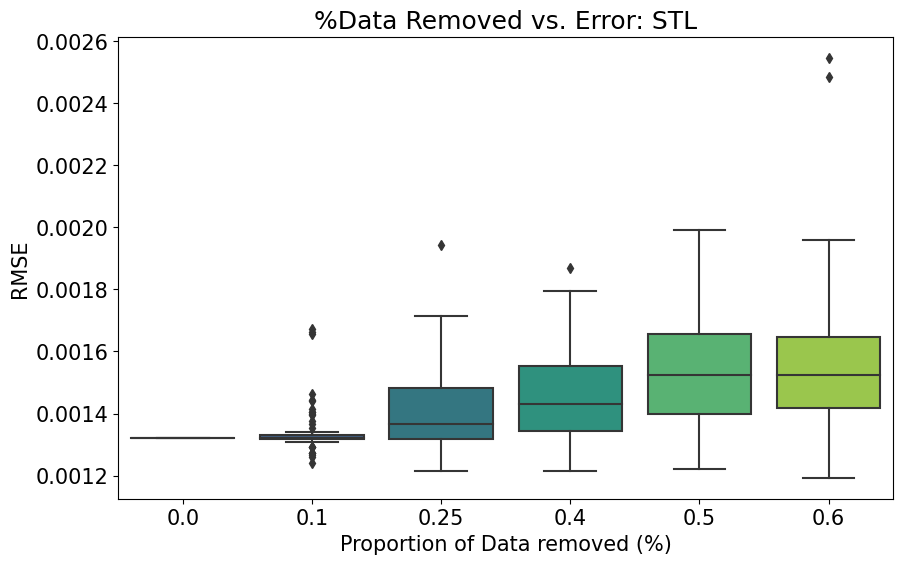

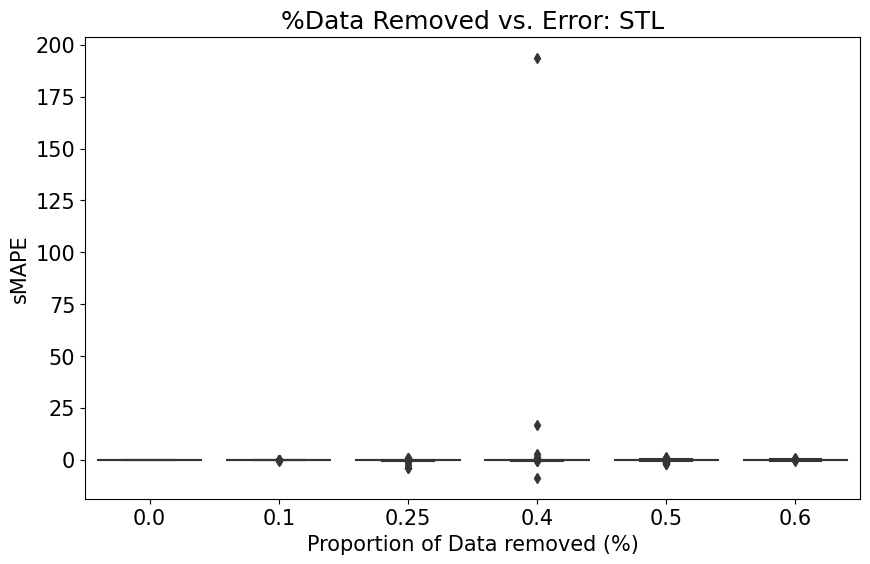

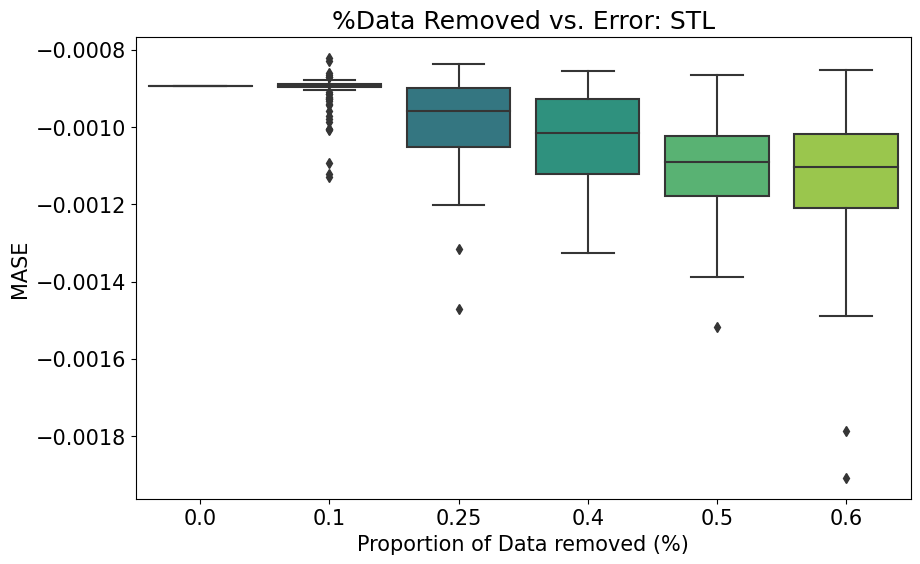

In [29]:
rmse_df=to_df(rmse_dist, to_remove, 'RMSE')
error_boxplot(rmse_df, 'RMSE', 'STL')
smape_df=to_df(smape_dist, to_remove, 'sMAPE')
error_boxplot(smape_df, 'sMAPE', 'STL')
mase_df=to_df(mase_dist, to_remove, 'MASE')
error_boxplot(mase_df, 'MASE', 'STL')

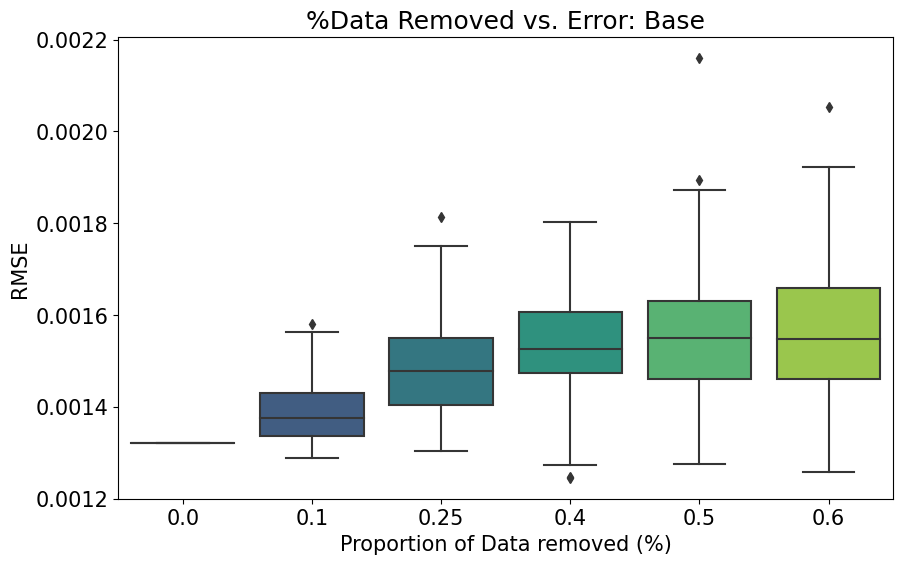

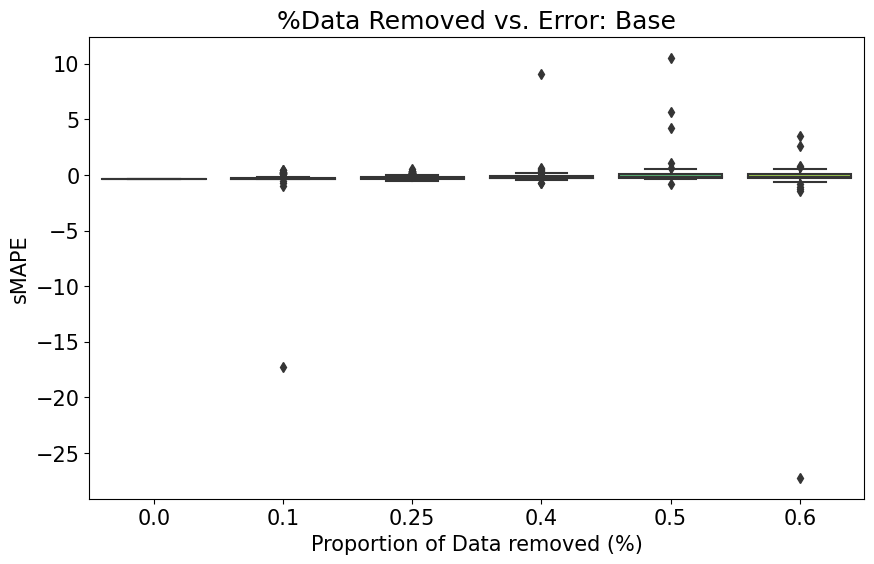

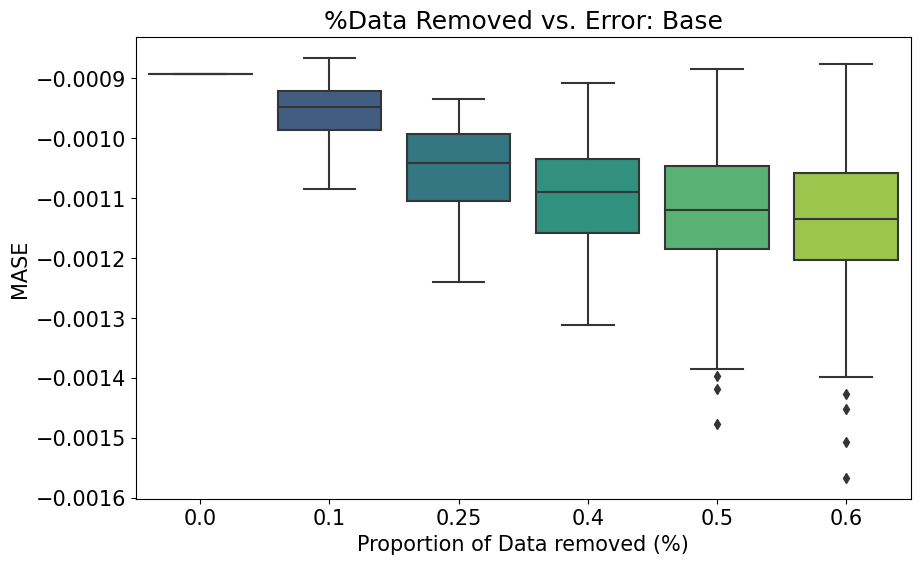

In [37]:
base_rmse_df=to_df(rmse_dist, to_remove, 'RMSE')
error_boxplot(base_rmse_df, 'RMSE', 'Base')
base_smape_df=to_df(smape_dist, to_remove, 'sMAPE')
error_boxplot(base_smape_df, 'sMAPE', 'Base')
base_mase_df=to_df(mase_dist, to_remove, 'MASE')
error_boxplot(base_mase_df, 'MASE', 'Base')

### Post-hoc procedure for ranking models
- What type of error do I want to minimize and why?

For example, I could use the Hochberg post-hoc method to reduce the number of false positives. This would mean that I would prioritize against incorrectly rejecting the true null hypothesis. I could use the true results (NPP values) as a control and the different models to compare against. The baseline would be Annette's method to calculate NPP. 

In [ ]:
rmse_long=rmse_df.melt(var_name='removed', value_name='rmse')

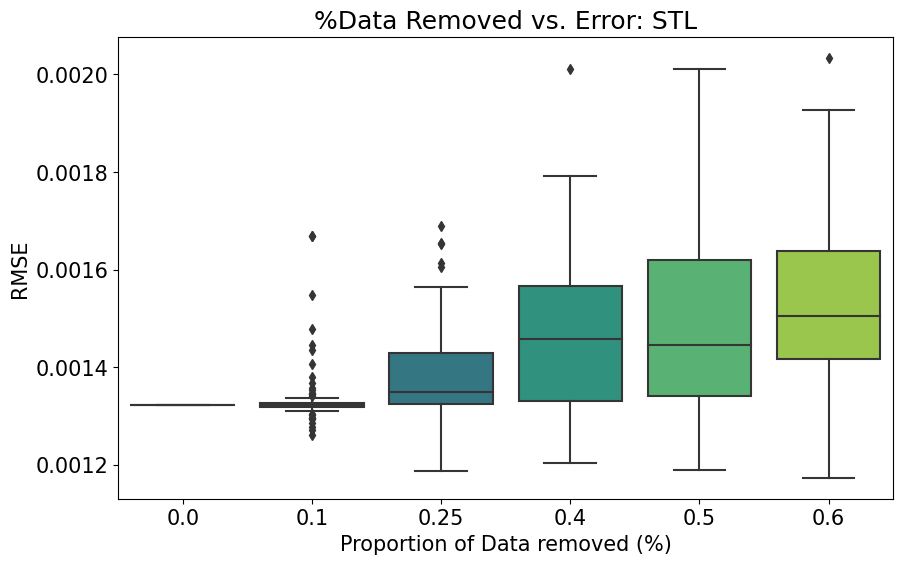

In [18]:
import seaborn as sns

error_long=rmse_df.melt(var_name='removed', value_name='rmse')
fig,axs=plt.subplots(figsize=(10,6))
sns.boxplot(data=error_long, x='removed',y='rmse', palette=sns.color_palette("viridis"))
axs.set_xlabel('Proportion of Data removed (%)')
axs.set_ylabel('RMSE')
axs.set_title('%Data Removed vs. Error: STL')
plt.show()

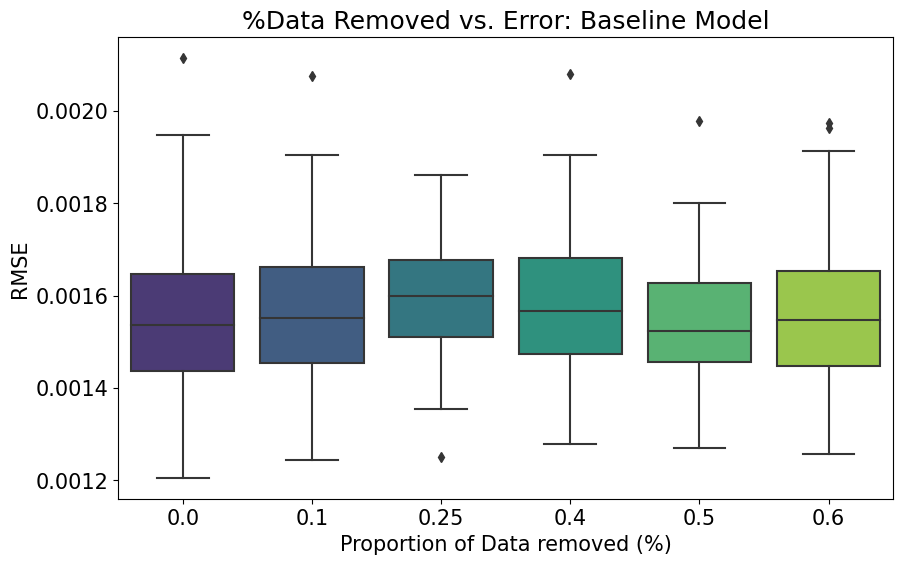

In [16]:
#### For baseline model
bs_rmse_df=pd.DataFrame(rmse_dist)
bs_rmse_df.columns = to_remove
bs_rmse_df.to_pickle('simulation_data/bs_rmse_df')

error_long=bs_rmse_df.melt(var_name='removed', value_name='rmse')
fig,axs=plt.subplots(figsize=(10,6))
sns.boxplot(data=error_long, x='removed',y='rmse', palette=sns.color_palette("viridis"))
axs.set_xlabel('Proportion of Data removed (%)')
axs.set_ylabel('RMSE')
axs.set_title('%Data Removed vs. Error: Baseline Model')
plt.show()

### CONSTRUCTION ZONE BEYOND THIS CELL###
![construction sign](https://media.istockphoto.com/id/1423867660/vector/traffic-road-barrier-road-closed-warning-barrier-flat-vector-illustrations-for-website-under.jpg?s=1024x1024&w=is&k=20&c=xXqtDUeaaaFlqN4cFyvv6rBLyzpuZF89cEKbus2Rw-M=)

### Perform time series train-test split and blocked cross validation (jk i don't think this works)
- Split time series data into training and testing
- Perform k-fold cross validation on varying blocks

**References**
- TS CV [blog post](https://goldinlocks.github.io/Time-Series-Cross-Validation/)
- Netpune AI [tutorial](https://neptune.ai/blog/select-model-for-time-series-prediction-task)
- Medium [blog post ](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4)

In [ ]:
# helper function to 
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=None)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
        
#     # Plot the data classes and groups at the end
#     ax.scatter(range(len(X)), [ii + 1.5] * len(X),
#                c=y, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) #+ ['class']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+1.2, -.1], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [45]:
# code from reference listed above
## class to define blocked split for training and testing data for time series CV
class BlockingTimeSeriesSplit():
    # initialize object
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    # class function to return # splits
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    # function to create blocked splits by works by adding margins at two positions. The first is between the 
    # training and validation folds in order to prevent the model from observing lag values which are used twice, 
    # once as an estimator (regressor) and another as a response. The second is between the folds used at 
    # each iteration in order to prevent the model from memorizing patterns from one iteration to the next.
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        # get size of each split
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
        # split evenly between training and testing
        margin = 0
        # get indices of data for each split 
        for i in range(self.n_splits):
            # set beginning and end of split
            start = i * k_fold_size
            stop = start + k_fold_size
            # get middle of split to start testing
            mid = int(0.5 * (stop - start)) + start
            # pause function to return splits for training and testing
            yield indices[start: mid], indices[mid + margin: stop]

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# visualize split for normal time series split and blocking
cvs = [TimeSeriesSplit, BlockingTimeSeriesSplit]

for cv in cvs:
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_cv_indices(this_cv, X, y, ax, n_splits)

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
            ['Testing set', 'Training set'], loc=(1.02, .8))
    plt.tight_layout()
    fig.subplots_adjust(right=.7)
        
plt.show()

In [37]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
# create time series split object
tscv = TimeSeriesSplit(n_splits = 4)
# set error metrics
rmse = []
# run grab training indices from truth data
NPP_truth=tsd_df.NPP.values
# for train_index, test_index in tscv.split(cross_validation):
#     cv_train, cv_test = cross_validation.iloc[train_index], cross_validation.iloc[test_index]
    
#     arma = sm.tsa.ARMA(cv_train, (2,2)).fit(disp=False)
    
#     predictions = arma.predict(cv_test.index.values[0], cv_test.index.values[-1])
#     true_values = cv_test.values
#     rmse.append(sqrt(mean_squared_error(true_values, predictions)))
    
# print("RMSE: {}".format(np.mean(rmse)))

In [43]:
counter=0
for train_index, test_index in tscv.split(NPP_truth):
    print(counter)
    print(f'train: {train_index}')
    print(f'test: {test_index}')
    counter+=1

0
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
test: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
1
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
test: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
2
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
test: [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
3
train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 